# Fragment based *de novo* drug design

In this notebook, we explore how to perform fragment based de novo drug design.

The way the algorithm works is simple: given an input SMILES, it is broken down into retrosynthetic building blocks.
A search is performed for each of those BBs to fetch fragments that are similar to it and analogues are generated from the resulting fragments.

It is important to note that the script only generates SMILES strings and does not perform any post-processing on it. That perhaps will be the goal of another notebook.

In [13]:
import re
import itertools
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from itertools import chain
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem, BRICS, Descriptors, FragmentCatalog, RDConfig
import os
import math
import sys

import time
timestr = time.strftime("%Y%m%d-%H%M%S")
import rdkit
print(f"I am RDKit version: {rdkit.__version__}")
print(f"I am python version: {sys.version}") 

I am RDKit version: 2023.09.5
I am python version: 3.10.0 (default, Feb 27 2024, 12:29:18) [Clang 15.0.0 (clang-1500.1.0.2.5)]


We will consider the SMILES of the following target molecule:

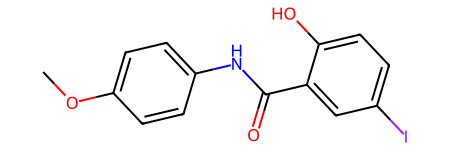

In [14]:
egfr_binder_2 = "COc1ccc(NC(=O)c2cc(I)ccc2O)cc1"
Chem.MolFromSmiles(egfr_binder_2)

In [15]:
class MolecularAnnealer:
    
    def __init__(self, target_smiles) -> None:
        
        self.target_smiles = target_smiles
        self.is_smiles_readable_by_rdkit = self.check_smiles_readable_by_rdkit()
        self.library = open('data/generated_chemical_space_'+ timestr, 'a+')
        self.generated_molecules = [] #collect all generated molecules at the end
        self.prepare_fragment_catalog() #prepare fragment catalog for the generation process
        self.write_fragments() #write the fragments to a file
        
    def check_smiles_readable_by_rdkit(self) -> bool:
        """
        Check if a SMILES string is readable by RDKit.
    
        Parameters:
        - smiles (str): The SMILES string to check.
    
        Returns:
        - bool: True if RDKit can read the SMILES string, False otherwise.
        """
        
        mol = Chem.MolFromSmiles(self.target_smiles)
        if mol is not None:
            print("SMILES is valid and readable by RDKit. Proceeding... \n")
            return True
        
        else:      
            print("SMILES is invalid and not readable by RDKit. Please check and try again.")
            sys.exit(1) # Exit the program
    
    def prepare_fragment_catalog(self) -> None:
        """This method reads SMILES from the ZINC database, 
          and generates a synthetic fragment database using BRICS decomposition.
        """

        # Load smiles from the ZINC database
        zinc = 'data/ZINC_smiles_database.csv'
        zinc_smiles = [i.split(',')[1] for i in open(zinc, 'r').read().splitlines()][1:] # Read the 2nd column with SMILES strings from the file
        zinc_mol = [Chem.MolFromSmiles(i) for i in zinc_smiles] # Convert SMILES strings to mol objects

        print("Fragmenting the ZINC database... \n")
        
        # Generate synthetic fragment database
        generic_frag_database = [BRICS.BRICSDecompose(i) for i in zinc_mol] # Decomposes molecules into fragments
        self.unique_frag_database = list(set(chain.from_iterable(generic_frag_database))) # keep the unique fragments 
        
    def write_fragments(self) -> None:
        """The function writes the synthetic fragment database to a file named ‘ZINC_fragments’.
        """
        frag_manager = open('data/ZINC_fragments', 'w')
        to_write = '\n'.join(self.unique_frag_database)
        frag_manager.write(to_write)
        frag_manager.close()
        
    def tanimoto_similarity(self, mol1, mol2) -> float:
        """calculates the Tanimoto similarity between two molecular fingerprints.

        Args:
            mol1 (obj): mol object of the first molecule
            mol2 (obj): mol object of the second molecule

        Returns:
            float: Tanimoto similarity between the two molecules
        """
        # Tanimoto similarity calculation
        fp_1 = AllChem.GetMorganFingerprint(mol1, 2)
        fp_2 = AllChem.GetMorganFingerprint(mol2, 2)
        return DataStructs.TanimotoSimilarity(fp_1, fp_2)
    
    def fetch_similar_fragments(self, target_cpd, n=7, threshold=0.4):
        """For each fragment from the target molecule, this method finds top5 similar fragments to it in the synthetic fragment database 
           based on Tanimoto similarity, using the specified threshold.
           These similar fragments are then returned.

        Args:
            target_cpd (string): SMILES string of the target compound
            n (int, optional): default number of similar fragments to return. Defaults to 5.
            threshold (float, optional): Minimum Tanimoto similarity threshold. Defaults to 0.4.

        Returns:
            list: List of similar fragments
        """
        # Find similar fragments in the synthetic fragment database using Tanimoto similarity
        score_frag = []
        target_mol = Chem.MolFromSmiles(target_cpd)
        
        #iterate through the synthetic fragment database to find fragments similar to those in target compound
        for i in self.unique_frag_database:
            
            cur_frag_mol = Chem.MolFromSmiles(i)
            similarity = self.tanimoto_similarity(target_mol, cur_frag_mol)
            
            if similarity >= threshold:
                score_frag.append((i, similarity)) #append the fragment and its similarity score to the list
                
        sorted_tuples = sorted(score_frag, key=lambda x: x[-1], reverse=True) #sort the list of tuples based on the similarity score, in descending order
        print("sorted tuples: ",sorted_tuples)
        
        chosen_fragments = [k[0] for k in sorted_tuples[:n]] #return the top n fragments with the highest similarity scores
        print("chosen fragments: ",chosen_fragments,'\n')
        
        return chosen_fragments
    
    def SMILES_decomposer(self) -> None:
        """decomposes the target compound into fragments using BRICS decomposition.
        """
        self.target_fragments = list(BRICS.BRICSDecompose(Chem.MolFromSmiles(self.target_smiles)))
        print("Target molecule fragments: ",self.target_fragments,'\n')
        
    def get_alternative_target_fragments(self) -> None:
        """collects alternative fragments for all target fragments.
        """        
        self.all_replaceable_fragments = [] #list to store all the chosen fragments returned from fetch_similar_fragments() method
        counter = 0
        
        for i in self.target_fragments:
            print('Searching the catalog for alternative chemical fragments ...' + str(counter + 1))
            target_ds = Chem.MolToSmiles(Chem.MolFromSmiles(i))
            self.all_replaceable_fragments.append(self.fetch_similar_fragments(target_ds, 7))
            counter += 1
        
        print("Total replaceable fragments",self.all_replaceable_fragments,'\n')
        print('Filling in all the possible fragments for different parts of your target compound ...')
        
    def generate_frag_templates(self) -> None:
        """" method creates potential compound templates using the collected replaceable fragments.
        this is done by taking the Cartesian product of the replaceable fragments using the product() function.
        This results in a list of all possible combinations of the replaceable fragments."""
        
        self.potential_cpd_templates = list(itertools.product(*self.all_replaceable_fragments)) 
        print("potential compound templates: ",self.potential_cpd_templates,'\n')
        
    def build_frag(self, max_compounds=10):
        """method merges fragments together to generate compounds, avoiding duplicates in the process.

        Args:
            max_compounds (int, optional): Compounds to generate with a given fragment. Defaults to 10.
        """
        self.generate_frag_templates()
        print('Stitching fragments together to generate compounds...')
 
        for current_template in self.potential_cpd_templates:
            fragms = [Chem.MolFromSmiles(x) for x in sorted(current_template)]
            ms = BRICS.BRICSBuild(fragms)
            
            for i, prod in enumerate(ms):
                if i >= max_compounds:
                    break
 
                sampler = Chem.MolToSmiles(prod, True)
                # Check if the compound is unique
                print(sampler)
                if sampler not in self.generated_molecules:
                    self.generated_molecules.append(sampler)
                    self.library.write(sampler + '\n')
                    
        return self.generated_molecules

In [16]:
def main():
    
    Opening_message = """
    Welcome to Molecular Annealer!
    It is a programme that generates a library of molecules similar to a given input using scaffold hopping 
    and R-group replacement.\n
    """
    
    print(Opening_message)
    
    # Run Molgen for a sample molecule from the egfr library:
    egfr_binder_2 = 'COc1ccc(NC(=O)c2cc(I)ccc2O)cc1'
    #egfr_binder_2 = input('Input your small molecule of interest')
    
    #Molecular Annealer
    sampler = MolecularAnnealer(egfr_binder_2)
    sampler.SMILES_decomposer()
    sampler.get_alternative_target_fragments()
    get_generated_compounds = sampler.build_frag()
    print(get_generated_compounds) #print the generated compounds as a list
 
if __name__ == '__main__':
    main()


    Welcome to Molecular Annealer!
    It is a programme that generates a library of molecules similar to a given input using scaffold hopping 
    and R-group replacement.

    
SMILES is valid and readable by RDKit. Proceeding... 

Fragmenting the ZINC database... 

Target molecule fragments:  ['[5*]N[5*]', '[3*]OC', '[1*]C([6*])=O', '[16*]c1ccc([16*])cc1', '[16*]c1cc(I)ccc1O'] 

Searching the catalog for alternative chemical fragments ...1
sorted tuples:  [('[5*]N[5*]', 1.0)]
chosen fragments:  ['[5*]N[5*]'] 

Searching the catalog for alternative chemical fragments ...2
sorted tuples:  [('[3*]OC', 1.0)]
chosen fragments:  ['[3*]OC'] 

Searching the catalog for alternative chemical fragments ...3
sorted tuples:  [('[1*]C([1*])=O', 1.0), ('[1*]C([6*])=O', 1.0), ('[6*]C([6*])=O', 1.0), ('[1*]C(=O)C([6*])=O', 0.5), ('[1*]C(=O)C([1*])=O', 0.5), ('[4*]CC([6*])=O', 0.46153846153846156), ('[1*]C(=O)C[7*]', 0.46153846153846156), ('[6*]C(=O)C[8*]', 0.46153846153846156), ('[1*]C(=O)C[4*]', 0